<a href="https://colab.research.google.com/github/mimiachiu/Deep-Learning-with-Python-Book/blob/master/Ch08_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install keras

In [ ]:
#載入預先訓練的Inception V3模型
from keras.applications import inception_v3
from keras import backend as K

K.set_learning_phase(0)
model = inception_v3.InceptionV3(weights='imagenet', include_top=False)

Using TensorFlow backend.


87916544/87910968 [==============================] - 1s 0us/step


In [ ]:
#選擇Inception V3模型的其中4個層並設定貢獻係數
layer_contributions = {
    'mixed2': 0.2,
    'mixed3': 3.,
    'mixed4': 2.,
    'mixed5': 1.5,
}

In [ ]:
#定義損失最大化
layer_dict = dict([layer.name, layer] for layer in model.layers)

loss = K.variable(0.)
for layer_name in layer_contributions:
    coeff = layer_contributions[layer_name]
    activation = layer_dict[layer_name].output
    scaling = K.prod(K.cast(K.shape(activation), 'float32'))

    loss = loss + coeff * K.sum(K.square(activation[:, 2:-2, 2:-2, :])) / scaling

In [ ]:
#梯度上升處理程序
dream = model.input
print(dream.shape)

grads = K.gradients(loss, dream)[0]
grads /= K.maximum(K.mean(K.abs(grads)), 1e-7)

outputs = [loss, grads]
fetch_loss_and_grads = K.function([dream], outputs)

def eval_loss_and_grads(x):
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value, grad_values

def gradient_ascent(x, iterations, step, max_loss=None):
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads(x)
        if max_loss is not None and loss_value > max_loss:
            break
        print('...Losss value at', i, ':', loss_value)
        print('...grad value at', i, ':', grad_values)
        x += step * grad_values
    return x

(None, None, None, 3)


In [ ]:
#輔助函式
import scipy
from keras.preprocessing import image
import numpy as np

def preprocess_image(image_path):
    img = image.load_img(image_path)
    img = image.img_to_array(img)
    print(img.shape)
    img = np.expand_dims(img, axis=0)
    print(img.shape)
    img = inception_v3.preprocess_input(img)
    return img

def deprocess_image(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((x.shape[1], x.shape[2], 3))
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def resize_img(img, size):
    img = np.copy(img)
    factors = (1,
               float(size[0]) / img.shape[1],
               float(size[1]) / img.shape[2],
               1)
    return scipy.ndimage.zoom(img, factors, order=1)

def save_img(img, fname):
    pil_img = deprocess_image(np.copy(img))
    #scipy.misc.imsave(fname, pil_img)
    import imageio
    imageio.imwrite(fname, pil_img)

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving original_photo_deep_dream.jpg to original_photo_deep_dream.jpg


In [ ]:
#在不同的連續比例的圖片上執行梯度上升
step = 0.01
num_octave = 3
octave_scale = 1.4
iterations = 20
max_loss = 10.

base_image_path = 'original_photo_deep_dream.jpg'
img = preprocess_image(base_image_path)

original_shape = img.shape[1:3]
successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)
successive_shapes = successive_shapes[::-1]

original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0])

for shape in successive_shapes:
    print('Processing image shape', shape)
    img = resize_img(img, shape)
    img = gradient_ascent(img, iterations=iterations, step=step, max_loss=max_loss)
    upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
    same_size_original = resize_img(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img
    img += lost_detail
    shrunk_original_img = resize_img(original_img, shape)
    save_img(img, fname='dream_at_scale_' + str(shape) + '.png')
save_img(img, fname='final_dream.png')

(768, 1024, 3)
(1, 768, 1024, 3)
Processing image shape (391, 522)
...Losss value at 0 : 1.5900116
...grad value at 0 : [[[[ 1.16902888e-02  3.43708470e-02 -1.32345110e-02]
   [ 4.77137603e-02  3.67979445e-02 -4.06496748e-02]
   [-4.57518734e-02  2.23843511e-02 -8.76080245e-02]
   ...
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]

  [[ 1.52372997e-02  4.38868590e-02 -3.88031527e-02]
   [ 3.53992940e-03 -3.25593688e-02 -9.15002003e-02]
   [-1.79445803e-01 -7.42530003e-02 -1.82308018e-01]
   ...
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]

  [[ 2.27475278e-02  3.06970198e-02 -6.62221462e-02]
   [-7.30983466e-02 -1.49810817e-02 -1.30072966e-01]
   [-2.87073374e-01  9.18914974e-02 -1.32441506e-01]
   ...
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
   [ 0.

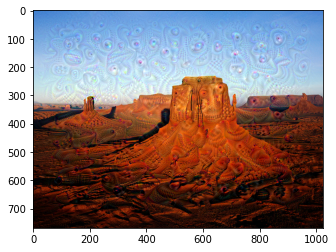

In [ ]:
#顯示DeepDream圖片
from matplotlib import pyplot as plt
plt.imshow(deprocess_image(np.copy(img)))
plt.show()